In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install bitstring

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 KB 2.8 MB/s eta 0:00:00


In [4]:
pip install komm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for komm: filename=komm-0.7.1-py3-none-any.whl size=56606 sha256=f9eec042ddebade9990f6c81f286f3f8f2d50eac8e650d6395578922a69b3bee
  Stored in directory: /root/.cache/pip/wheels/84/c6/4b/4340e6f944c4edce43ced625131bff3c695bfbeefbb41000f2
Successfully built komm


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import standard_normal
import wave
from bitstring import BitArray
from scipy import special
import math
import struct
import komm
import sys

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
def coherent_AWGN_Channel(InputSig, SNR_dB):
  SNR = 10**(SNR_dB/10) 
  SigLength = len(InputSig)
  #SNR = 2*EbN0 # energy of the symbol
  SigPower = np.sum(abs(InputSig)**2)/SigLength        # power of the input signal
  #SigPower = 1                                        
  N0 = SigPower/SNR                                   # noise spectral density 
  # noise
  noise = np.sqrt(N0/2)*(standard_normal(InputSig.shape)+1j*standard_normal(InputSig.shape))
  # output
  OutputSig = InputSig+noise
  return OutputSig

In [8]:
def non_coherent_AWGN_Channel(InputSig, SNR_dB):
  SNR = 10**(SNR_dB/10)
  ambig_phase = ( np.random.randint(1,8) ) * np.pi/4
  #print(math.degrees(ambig_phase))
  shifted_input = [sig*(np.e**(ambig_phase*1j)) for sig in InputSig]
  shifted_input = np.array(shifted_input)
  awgn = komm.AWGNChannel(snr=SNR, signal_power=1)
  output = awgn(shifted_input)
  return output

In [9]:
def coherent_qpsk_mod(input):
  N = len(input)
  chunks = [input[i:i+2] for i in range(0, N, 2)]
  # constelation points
  point0 = 1
  point1 = 1j
  point2 = -1j
  point3 = -1
  # mapping dictionaries
  qpsk_mod = {'00':point0, '01':point1, '10': point2, '11':point3}   # mapping dictionary

  ModulatedSig = np.zeros(int(N/2), dtype=complex)
  for i in range(len(chunks)):
    ModulatedSig[i] = qpsk_mod[chunks[i]]
  
  return ModulatedSig

In [10]:
def coherent_qpsk_demod(input):
  out = ''
  qpsk_demod = {0:'00', 1:'01', 2:'10', 3:'11'}
  for val in input:
    elements = [np.real(val), np.imag(val), -1*np.imag(val), -1*np.real(val)]
    idx = np.argmax(elements)
    out += qpsk_demod[idx]
  return(out)

In [11]:
def non_coherent_qpsk_mod(input):
  chunks = [input[i:i+2] for i in range(0, len(input), 2)]
  N = len(input)   
  # constelation points
  point0 = 1
  point1 = 1j
  point2 = -1j
  point3 = -1
  # mapping dictionaries
  qpsk_phase_point   =   {0: point0, 90: point1, 270: point2, 180: point3}    # modulation phase to point mapper
  qpsk_mod_phase = {'00':0, '01':90, '11':180, '10':270}                      # modulation string to point mapper

  ModulatedSig = np.zeros(int(N/2), dtype=complex)
  ModulatedSig[0] = 1
  for i in range(1, len(chunks)):
    phase_diff = qpsk_mod_phase[chunks[i]] - qpsk_mod_phase[chunks[i-1]] # differential coding
    #ModulatedSig[i] = np.cos(math.radians(phase_diff)) + 1j*np.sin(math.radians(phase_diff))
    if phase_diff<0:
      phase_diff = phase_diff + 360
    ModulatedSig[i] = qpsk_phase_point[phase_diff]
  return ModulatedSig

In [331]:
def non_coherent_qpsk_demod(input):

  qpsk_dec =   {0: '00', 1: '01', 2: '10', 3: '11'}   # qpsk point to string mapper

  output = '00'

  current_phase = 0
  for i in range(1, len(input)):
    phase = math.degrees(np.angle(input[i])) 
    if phase<0:
      phase = phase + 360
    phase_diff = ( math.degrees(np.angle(input[i])) - math.degrees(np.angle(input[0])) ) % 360
    print('phase diff: ', phase_diff)
    current_phase += phase_diff
    if current_phase>360:
      current_phase = current_phase - 360
    print('current phase: ', current_phase)

    if 0<=current_phase<=45:
      output += qpsk_dec[0]
      print(0)
    elif 45<current_phase<=135:
      output += qpsk_dec[1]
      print(1)
    elif 135<current_phase<=225:
      output += qpsk_dec[3]
      print(3)
    elif 225<current_phase<=315:
      output += qpsk_dec[2]
      print(2)
    elif 315<current_phase<=360:
      output += qpsk_dec[0]
      print(0)
    
    print('---------------------------------')

  return output

In [13]:
def diff_encode(tx_bin, Nbits, Ndummy):
    """
    Differential encoder
    
    Parameters
    ----------
    tx_bin : input binary array
    Nbits : number of bits to be transmitted
    Ndummy : number of dummy bits to cover any locking delay
    
    Returns
    
    -------
    tx_diff : encoded binary array for transmission
    """
    # Differential Encoding:
    tx_diff = np.zeros(1, dtype=bool)
    for i in range(Nbits + Ndummy):
        tx_diff = np.append(tx_diff, tx_diff[i]^tx_bin[i])
    return tx_diff

In [14]:
def diff_decode(rx_diff, Nbits):
    """
    Differential decoder
    
    Parameters
    ----------
    rx_diff : received encoded binary array
    Nbits : number of bits to be transmitted
    
    Returns
    
    -------
    rx_bin : decoded binary array
    """
    rx_bin = np.empty(0, dtype=bool)
    Nbits = Nbits-1
    for i in range(Nbits):
        rx_bin = np.append(rx_bin, rx_diff[i]^rx_diff[i+1]).astype(bool)
    return rx_bin

In [378]:
def non_coherent_qpsk_demod1(input):

  qpsk_dec =   {0: '00', 1: '01', 2: '11', 3: '10'}   # qpsk point to string mapper

  indx = 0
  out = '00'
  for i in range(1, len(input)):
    phase_diff = ( math.degrees(np.angle(input[i])) - math.degrees(np.angle(input[0])) ) % 360
    if phase_diff<0:
      phase_diff = phase_diff+360

    #print('delat_angle: ', phase_diff)
    
    if 0<=phase_diff<=45:
      indx = indx+0
      #print('my_angle: ', 0)
    if 45<phase_diff<=135:
      indx = indx+1
      #print('my_angle: ', 90)
    if 135<phase_diff<=225:
      indx = indx+2
      #print('my_angle: ', 180)
    if 225<phase_diff<=315:
      indx = indx+3
      #print('my_angle: ', 270)
    if 315<phase_diff<=360:
      indx = indx+0
      #print('my_angle: ', 0)

    
    if indx>3:
      indx = indx-4

    #print('indx: ', indx)
    
    #print('------------')

    out+=qpsk_dec[indx]
  
  return out[2:]


In [15]:
audio_path = 'drive/MyDrive/DigitCommProject/my_voice1.wav'

In [16]:
InputObj = wave.open(audio_path,'r')

In [17]:
print ("Number of frames: ",InputObj.getnframes())

Number of frames:  211904


In [18]:
print('Sample width: ', InputObj.getsampwidth())

Sample width:  2


In [19]:
print('Number of channels: ' , InputObj.getnchannels())

Number of channels:  1


In [20]:
rate = InputObj.getframerate()
print('Smpling frequency: ', rate)

Smpling frequency:  48000


In [21]:
InputBytes = InputObj.readframes(InputObj.getnframes())

In [22]:
print('Numebr of input bytes: ', len(InputBytes))

Numebr of input bytes:  423808


In [23]:
header_bytes = InputBytes[0:44]
Information_bytes = InputBytes[44:]

In [24]:
print('Number of information bytes: ', len(Information_bytes))

Number of information bytes:  423764


In [25]:
Information_bits = ''
for i in range(len(Information_bytes)):
  temp = '{0:08b}'.format(Information_bytes[i])
  Information_bits += temp
print('Number of input information bits: ', len(Information_bits))

Number of input information bits:  3390112


# Part a

### Coherent QPSK:

Experiment:

In [112]:
N = len(Information_bits)
EbN0_db_range = [0, 5, 10, 15]

In [ ]:
output_data = []  # to store output data of all SNRs
BER_coherent = []

for EbN0_db in EbN0_db_range:

  ModulatedSig = coherent_qpsk_mod(Information_bits)
  ChannelOutput = coherent_AWGN_Channel(ModulatedSig, 2*EbN0_db)
  DemodulatedSig = coherent_qpsk_demod(ChannelOutput)

  output_data.append(DemodulatedSig)

  num_errors = sum(a!=b  for a, b in zip(Information_bits, DemodulatedSig))
  BER_coherent.append(num_errors/N)

  print('Bit error rate in Eb/N0 =', EbN0_db, 'dB :', num_errors/N)


Bit error rate in Eb/N0 = 0 dB : 0.15860537940929384
Bit error rate in Eb/N0 = 5 dB : 0.0007793252848283478
Bit error rate in Eb/N0 = 10 dB : 0.0
Bit error rate in Eb/N0 = 15 dB : 0.0


Theory:

In [ ]:
BER_th = []
for EbN0_db in EbN0_db_range:
  EbN0 = 10**(EbN0_db/10) 
  Q = 0.5 - 0.5*special.erf((2*EbN0)/np.sqrt(2))
  p4 = 2*Q*(1-0.5*Q)
  pb = 0.5*p4
  BER_th.append(pb)
  print('Bit error probability in Eb/N0 =', EbN0_db, 'dB :', pb)

Bit error probability in Eb/N0 = 0 dB : 0.022491347696349424
Bit error probability in Eb/N0 = 5 dB : 1.2698142536653275e-10
Bit error probability in Eb/N0 = 10 dB : 0.0
Bit error probability in Eb/N0 = 15 dB : 0.0


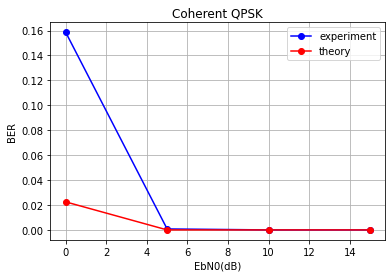

In [ ]:
plt.plot(EbN0_db_range, BER_coherent, 'o-',label='experiment', color='b')
plt.plot(EbN0_db_range, BER_th, 'o-',label='theory', color='r')
plt.xlabel('EbN0(dB)')
plt.ylabel('BER')
plt.grid(True)
plt.title('Coherent QPSK')
plt.legend()
plt.show()

output data to .wav audio file conversion:

In [ ]:
output_audio_base_path = 'drive/MyDrive/DigitCommProject/output_audios/part_a'

In [ ]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_a/coherent_EbN0_0.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data[0], 2).to_bytes((len(output_data[0]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [ ]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_a/coherent_EbN0_5.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data[1], 2).to_bytes((len(output_data[1]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [ ]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_a/coherent_EbN0_15.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data[2], 2).to_bytes((len(output_data[2]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [ ]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_a/coherent_EbN0_20.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data[3], 2).to_bytes((len(output_data[3]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

### Non-coherent QPSK:

In [441]:
new_InputBits = '00' + Information_bits
output_data_noncoherent = []
BER_noncoherent = []


for EbN0_db in [0, 5, 10, 15]:
  # modulation
  ModulatedSig = non_coherent_qpsk_mod(new_InputBits)
  # non-coherent channel
  ChannelOutput = non_coherent_AWGN_Channel(ModulatedSig, 2*EbN0_db)
  # demodulation
  DemodulatedSig = non_coherent_qpsk_demod1(ChannelOutput)

  num_errors = sum(a!=b  for a, b in zip(Information_bits, DemodulatedSig))
  ber = num_errors/len(Information_bits)
  BER_noncoherent.append(ber)
  output_data_noncoherent.append(DemodulatedSig)

  print('Bit error rate in Eb/N0 =', EbN0_db, 'dB :', ber)

Bit error rate in Eb/N0 = 0 dB : 0.49993658026637466
Bit error rate in Eb/N0 = 5 dB : 0.4960591272500732
Bit error rate in Eb/N0 = 10 dB : 0.0
Bit error rate in Eb/N0 = 15 dB : 0.0


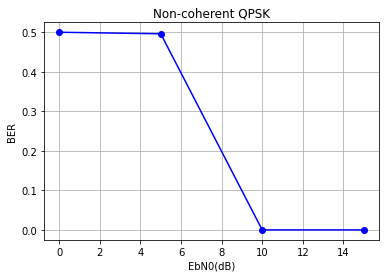

In [442]:
plt.plot(EbN0_db_range, BER_noncoherent, 'o-',label='experiment', color='b')
plt.xlabel('EbN0(dB)')
plt.ylabel('BER')
plt.grid(True)
plt.title('Non-coherent QPSK')
plt.show()

In [443]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_a/noncoherent_EbN0_0.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data_noncoherent[0], 2).to_bytes((len(output_data_noncoherent[0]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [444]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_a/noncoherent_EbN0_5.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data_noncoherent[1], 2).to_bytes((len(output_data_noncoherent[1]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [445]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_a/noncoherent_EbN0_10.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data_noncoherent[2], 2).to_bytes((len(output_data_noncoherent[2]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [447]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_a/noncoherent_EbN0_15.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data_noncoherent[3], 2).to_bytes((len(output_data_noncoherent[3]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

# Part b

## Coherent

BCH(15, 11)

In [54]:
# parameters of the coder
n1 = 15
k1 = 11
m1 = 4
t1 = 1
code1 = komm.BCHCode(m1 ,t1) 
print('Code length:', code1.length)
print('Code dimension:', code1.dimension)

Code length: 15
Code dimension: 11


In [55]:
N = len(Information_bits)
InputSym1 = [ Information_bits[i:i+k1] for i in range(0, N, k1)]
InputSym1_ = []
for item in InputSym1:
  temp = list(int(str(x)) for x in item)
  InputSym1_.append(temp)

In [28]:
CodedSignal1 = [code1.encode(p) for p in InputSym1_]
print('shape: ', np.shape(CodedSignal1))
CodedSignal1 = np.array(CodedSignal1).ravel()
print('after reshape: ', np.shape(CodedSignal1))

shape:  (308192, 15)
after reshape:  (4622880,)


In [113]:
#EbN0_db_range_coding1 = [ EbN0+10*np.log10(k1/n1) for EbN0 in [5, 10, 15, 20]]
EbN0_db_range_coding1 = [(k1/n1)*i for i in EbN0_db_range]
output_data_coherent_coding1 = []
BER_coherent_coding1 = []

qpsk = komm.PSKModulation(4, phase_offset=np.pi/4)
modulated = qpsk.modulate(CodedSignal1)

for EbN0_db in EbN0_db_range_coding1:
  snr = 2* ( 10**(EbN0_db/10) )
  awgn = komm.AWGNChannel(snr=snr, signal_power=1)
  ChannelOutput = awgn(modulated)
  demodulated = qpsk.demodulate(ChannelOutput)
  demodulated_reshape = np.array(demodulated).reshape(-1, n1)
  decoded = [code1.decode(p) for p in demodulated_reshape]
  decoded = np.array(decoded)
  decoded_ = np.ravel(decoded)

  #num_error = np.sum(Information_bits != decoded)
  num_error = np.sum(np.array(InputSym1_)!=decoded)
  output_data_coherent_coding1.append(decoded)

  #num_errors = sum(a!=b  for a, b in zip(Information_bits, decoded))
  BER_coherent_coding1.append(num_error/N)

  print('Bit error rate in SNR =', EbN0_db, 'dB :', num_error/N)

Bit error rate in SNR = 0.0 dB : 0.07439577217507858
Bit error rate in SNR = 3.6666666666666665 dB : 0.004488347287641234
Bit error rate in SNR = 7.333333333333333 dB : 5.309559094212816e-06
Bit error rate in SNR = 11.0 dB : 0.0


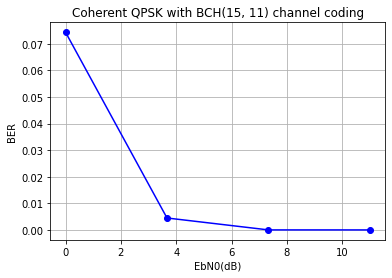

In [114]:
plt.plot(EbN0_db_range_coding1, BER_coherent_coding1, 'o-',label='experiment', color='b')
plt.xlabel('EbN0(dB)')
plt.ylabel('BER')
plt.grid(True)
plt.title('Coherent QPSK with BCH(15, 11) channel coding')
plt.show()

output data to .wav file connversion

In [117]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/coherent_coding1_EbN0_0.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_data = list(output_data_coherent_coding1[0].ravel())  # flattening
output_data = ''.join(str(x) for x in output_data) # converting to string
output_audio = int(output_data, 2).to_bytes((len(output_data) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [118]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/coherent_coding1_EbN0_4.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_data = list(output_data_coherent_coding1[1].ravel())  # flattening
output_data = ''.join(str(x) for x in output_data) # converting to string
output_audio = int(output_data, 2).to_bytes((len(output_data) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [119]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/coherent_coding1_EbN0_7.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_data = list(output_data_coherent_coding1[2].ravel())  # flattening
output_data = ''.join(str(x) for x in output_data) # converting to string
output_audio = int(output_data, 2).to_bytes((len(output_data) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [122]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/coherent_coding1_EbN0_11.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_data = list(output_data_coherent_coding1[3].ravel())  # flattening
output_data = ''.join(str(x) for x in output_data) # converting to string
output_audio = int(output_data, 2).to_bytes((len(output_data) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

BCH(15, 7)

In [448]:
# parameters of the coder
n2 = 15
k2 = 7
m2 = 4
t2 = 2
code2 = komm.BCHCode(m2 ,t2) 
print('Code length:', code2.length)
print('Code dimension:', code2.dimension)

Code length: 15
Code dimension: 7


In [514]:
N = len(Information_bits)
Information_bits_padded = Information_bits + '0000000000000000'
N_padded = len(Information_bits_padded)
InputSym2 = [ Information_bits_padded[i:i+k2] for i in range(0, N, k2)]
InputSym2_ = np.zeros((len(InputSym2), k2))
for i in range(len(InputSym2)):
  temp = list(int(str(x)) for x in InputSym2[i])
  InputSym2_[i] = temp

In [515]:
CodedSignal2 = [code2.encode(p) for p in InputSym2_]
print('shape of the coded signal: ', np.shape(CodedSignal2))
CodedSignal2 = np.array(CodedSignal2).ravel()
print('after reshape: ', np.shape(CodedSignal2))

shape of the coded signal:  (484302, 15)
after reshape:  (7264530,)


In [516]:
#EbN0_db_range_coding2 = [ EbN0+10*np.log10(k2/n2) for EbN0 in [5, 10, 15, 20]]
EbN0_db_range_coding2 = [(k2/n2)*i for i in EbN0_db_range]
output_data_coherent_coding2 = []
BER_coherent_coding2 = []

qpsk = komm.PSKModulation(4, phase_offset=np.pi/4)
modulated = qpsk.modulate(CodedSignal2)

for EbN0_db in EbN0_db_range_coding2:
  snr = 2* ( 10**(EbN0_db/10) )
  awgn = komm.AWGNChannel(snr=snr, signal_power=1)
  ChannelOutput = awgn(modulated)
  demodulated = qpsk.demodulate(ChannelOutput)
  demodulated_reshape = np.array(demodulated).reshape(-1, n2)
  decoded = [code2.decode(p) for p in demodulated_reshape]
  decoded = np.array(decoded)
  decoded_ = np.ravel(decoded)

  #num_error = np.sum(Information_bits != decoded)
  num_error = np.sum(np.array(InputSym2_)!=decoded)
  output_data_coherent_coding2.append(decoded)

  #num_errors = sum(a!=b  for a, b in zip(Information_bits, decoded))
  BER_coherent_coding2.append(num_error/N_new)

  print('Bit error rate in SNR =', EbN0_db, 'dB :', num_error/N_new)

Bit error rate in SNR = 0.0 dB : 0.029435588301750325
Bit error rate in SNR = 2.3333333333333335 dB : 0.002860375786772952
Bit error rate in SNR = 4.666666666666667 dB : 4.749102832530115e-05
Bit error rate in SNR = 7.0 dB : 0.0


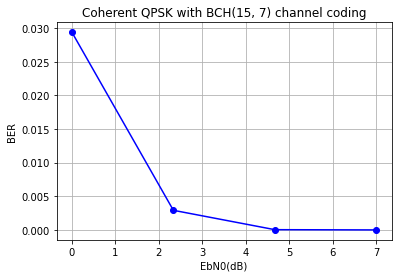

In [454]:
plt.plot(EbN0_db_range_coding2, BER_coherent_coding2, 'o-',label='experiment', color='b')
plt.xlabel('EbN0(dB)')
plt.ylabel('BER')
plt.grid(True)
plt.title('Coherent QPSK with BCH(15, 7) channel coding')
plt.show()

output data to .wav file connversion

In [527]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/coherent_coding2_EbN0_0.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_data = list(output_data_coherent_coding2[0].ravel())  # flattening
output_data = ''.join(str(x) for x in output_data) # converting to string
output_data = output_data[0:len(output_data)-2]
output_audio = int(output_data, 2).to_bytes((len(output_data) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [528]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/coherent_coding2_EbN0_2.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_data = list(output_data_coherent_coding2[1].ravel())  # flattening
output_data = ''.join(str(x) for x in output_data) # converting to string
output_data = output_data[0:len(output_data)-2]
output_audio = int(output_data, 2).to_bytes((len(output_data) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [529]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/coherent_coding2_EbN0_4.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_data = list(output_data_coherent_coding2[2].ravel())  # flattening
output_data = ''.join(str(x) for x in output_data) # converting to string
output_data = output_data[0:len(output_data)-2]
output_audio = int(output_data, 2).to_bytes((len(output_data) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [530]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/coherent_coding2_EbN0_7.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_data = list(output_data_coherent_coding2[3].ravel())  # flattening
output_data = ''.join(str(x) for x in output_data) # converting to string
output_data = output_data[0:len(output_data)-2]
output_audio = int(output_data, 2).to_bytes((len(output_data) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

## Non-coherent:

BCH(15, 11)

In [491]:
CodedSignal1_str = ''.join(str(x) for x in CodedSignal1)
CodedSignal1_str_new = '00' + CodedSignal1_str

In [498]:
output_data_noncoherent_coding1 = []
BER_noncoherent_coding1 = []


for EbN0_db in EbN0_db_range_coding1:
  # modulation
  ModulatedSig = non_coherent_qpsk_mod(CodedSignal1_str_new)
  # non-coherent channel
  ChannelOutput = non_coherent_AWGN_Channel(ModulatedSig, 2*EbN0_db)
  # demodulation
  DemodulatedSig = non_coherent_qpsk_demod1(ChannelOutput)
  # decoding
  DemodulatedSig_list = list(DemodulatedSig)
  DemodulatedSig_intarr = [int(x) for x in DemodulatedSig_list]
  DemodulatedSig_reshape = np.array(DemodulatedSig_intarr).reshape(-1, n1)
  decoded = [code1.decode(p) for p in DemodulatedSig_reshape]
  decoded = np.array(decoded).ravel()
  decoded_str = ''.join(str(x) for x in decoded)


  num_errors = sum(a!=b  for a, b in zip(Information_bits, decoded_str))
  ber = num_errors/len(Information_bits)
  BER_noncoherent_coding1.append(ber)
  output_data_noncoherent_coding1.append(decoded_str)

  print('Bit error rate in Eb/N0 =', EbN0_db, 'dB :', ber)

Bit error rate in Eb/N0 = 0.0 dB : 0.4997955819748728
Bit error rate in Eb/N0 = 3.6666666666666665 dB : 0.49812130100716434
Bit error rate in Eb/N0 = 7.333333333333333 dB : 0.0
Bit error rate in Eb/N0 = 11.0 dB : 0.0


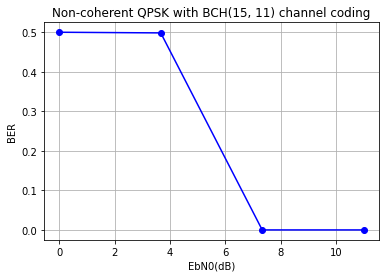

In [499]:
plt.plot(EbN0_db_range_coding1, BER_noncoherent_coding1, 'o-',label='experiment', color='b')
plt.xlabel('EbN0(dB)')
plt.ylabel('BER')
plt.grid(True)
plt.title('Non-coherent QPSK with BCH(15, 11) channel coding')
plt.show()

In [505]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/noncoherent_coding1_EbN0_0.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data_noncoherent_coding1[0], 2).to_bytes((len(output_data_noncoherent_coding1[0]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [506]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/noncoherent_coding1_EbN0_4.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data_noncoherent_coding1[1], 2).to_bytes((len(output_data_noncoherent_coding1[1]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [507]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/noncoherent_coding1_EbN0_7.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data_noncoherent_coding1[2], 2).to_bytes((len(output_data_noncoherent_coding1[2]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

In [509]:
sampleRate = rate # hertz
duration = 4.0 # seconds
obj = wave.open('drive/MyDrive/DigitCommProject/output_audios/part_b/noncoherent_coding1_EbN0_11.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(sampleRate)
output_audio = int(output_data_noncoherent_coding1[3], 2).to_bytes((len(output_data_noncoherent_coding1[3]) + 7) // 8, byteorder='big')
output_audio = header_bytes + output_audio
obj.writeframes( output_audio ) 

BCH(15, 7)

In [531]:
CodedSignal2_str = ''.join(str(x) for x in CodedSignal2)
CodedSignal2_str_new = '00' + CodedSignal2_str

In [534]:
output_data_noncoherent_coding2 = []
BER_noncoherent_coding2 = []


for EbN0_db in EbN0_db_range_coding2:
  # modulation
  ModulatedSig = non_coherent_qpsk_mod(CodedSignal2_str_new)
  # non-coherent channel
  ChannelOutput = non_coherent_AWGN_Channel(ModulatedSig, 2*EbN0_db)
  # demodulation
  DemodulatedSig = non_coherent_qpsk_demod1(ChannelOutput)
  # decoding
  DemodulatedSig_list = list(DemodulatedSig)
  DemodulatedSig_intarr = [int(x) for x in DemodulatedSig_list]
  DemodulatedSig_reshape = np.array(DemodulatedSig_intarr).reshape(-1, n2)
  decoded = [code1.decode(p) for p in DemodulatedSig_reshape]
  decoded = np.array(decoded).ravel()
  decoded_str = ''.join(str(x) for x in decoded)


  num_errors = sum(a!=b  for a, b in zip(Information_bits_padded, decoded_str))
  ber = num_errors/len(Information_bits)
  BER_noncoherent_coding2.append(ber)
  output_data_noncoherent_coding2.append(decoded_str)

  print('Bit error rate in Eb/N0 =', EbN0_db, 'dB :', ber)

Bit error rate in Eb/N0 = 0.0 dB : 0.49955075230552853
Bit error rate in Eb/N0 = 2.3333333333333335 dB : 0.4997740487629907
Bit error rate in Eb/N0 = 4.666666666666667 dB : 0.5003179835946423
Bit error rate in Eb/N0 = 7.0 dB : 0.5003380419289982
